# Table of Content:
 - Import Libraries & Load the data
 - Feature Engineering & Selection
 - Model Development
 - Model Evaluation
 - Best Model

## Import Libraries & Load the data

In [ ]:
!pip install pyspark

In [ ]:
# import modules from pyspark
from pyspark.sql import SparkSession
from pyspark.sql.types import *
from pyspark.sql.functions import *
from pyspark.sql import SQLContext
from pyspark.sql.functions import col

# setup the necessary contexts
spark = SparkSession.builder.enableHiveSupport().getOrCreate()
spark.sparkContext.setLogLevel("ERROR")
sqlContext = SQLContext(spark)

/usr/local/lib/python3.10/dist-packages/pyspark/sql/context.py:113: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# read the csv file and create the dataframe

file_location = "/content/drive/MyDrive/Colab Notebooks/Hackathon/OSU HackAI/triple-c/data/HousingDataset.csv"
file_type = "csv"

# CSV options
infer_schema = "true"
first_row_is_header = "true"
delimiter = ","

# The applied options are for CSV files. For other file types, these will be ignored.
df = spark.read.format(file_type) \
  .option("inferSchema", infer_schema) \
  .option("header", first_row_is_header) \
  .option("sep", delimiter) \
  .load(file_location)

# Get all column names as a list
columns = df.columns

# Exclude the first column name from the list
columns_to_select = columns[1:]
df = df.select(columns_to_select)

# Convert Spark DataFrame to Pandas DataFrame for plotting
pd_df = df.toPandas()
original_pd_df = pd_df.copy()
pd_df

,price,area,bedrooms,bathrooms,stories,mainroad,guestroom,basement,hotwaterheating,airconditioning,parking,prefarea,furnishingstatus
0,6090000,6615,4,2,2,yes,yes,no,yes,no,1,no,semi-furnished
1,5530000,6100,3,2,1,yes,no,yes,no,no,2,yes,furnished
2,3500000,4600,4,1,2,yes,no,no,no,no,0,no,semi-furnished
3,6090000,6600,3,1,1,yes,yes,yes,no,no,2,yes,semi-furnished
4,7962500,6000,3,1,4,yes,yes,no,no,yes,2,no,unfurnished
...,...,...,...,...,...,...,...,...,...,...,...,...,...
322,3675000,3600,2,1,1,yes,no,no,no,no,0,no,furnished
323,4060000,4320,3,1,2,yes,no,no,no,no,2,yes,furnished
324,2275000,1836,2,1,1,no,no,yes,no,no,0,no,semi-furnished
325,5943000,15600,3,1,1,yes,no,no,no,yes,2,no,semi-furnished


In [ ]:
df.printSchema()

root
 |-- price: integer (nullable = true)
 |-- area: integer (nullable = true)
 |-- bedrooms: integer (nullable = true)
 |-- bathrooms: integer (nullable = true)
 |-- stories: integer (nullable = true)
 |-- mainroad: string (nullable = true)
 |-- guestroom: string (nullable = true)
 |-- basement: string (nullable = true)
 |-- hotwaterheating: string (nullable = true)
 |-- airconditioning: string (nullable = true)
 |-- parking: integer (nullable = true)
 |-- prefarea: string (nullable = true)
 |-- furnishingstatus: string (nullable = true)



In [ ]:
pd_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 327 entries, 0 to 326
Data columns (total 13 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   price             327 non-null    int32 
 1   area              327 non-null    int32 
 2   bedrooms          327 non-null    int32 
 3   bathrooms         327 non-null    int32 
 4   stories           327 non-null    int32 
 5   mainroad          327 non-null    object
 6   guestroom         327 non-null    object
 7   basement          327 non-null    object
 8   hotwaterheating   327 non-null    object
 9   airconditioning   327 non-null    object
 10  parking           327 non-null    int32 
 11  prefarea          327 non-null    object
 12  furnishingstatus  327 non-null    object
dtypes: int32(6), object(7)
memory usage: 25.7+ KB


In [ ]:
from pyspark.sql.functions import col, count, when

# Check is there any missing values
missing_values = df.select([count(when(col(c).isNull(), c)).alias(c) for c in df.columns])
missing_values.show()

+-----+----+--------+---------+-------+--------+---------+--------+---------------+---------------+-------+--------+----------------+
|price|area|bedrooms|bathrooms|stories|mainroad|guestroom|basement|hotwaterheating|airconditioning|parking|prefarea|furnishingstatus|
+-----+----+--------+---------+-------+--------+---------+--------+---------------+---------------+-------+--------+----------------+
|    0|   0|       0|        0|      0|       0|        0|       0|              0|              0|      0|       0|               0|
+-----+----+--------+---------+-------+--------+---------+--------+---------------+---------------+-------+--------+----------------+



In [ ]:
df.show(5)

+-------+----+--------+---------+-------+--------+---------+--------+---------------+---------------+-------+--------+----------------+
|  price|area|bedrooms|bathrooms|stories|mainroad|guestroom|basement|hotwaterheating|airconditioning|parking|prefarea|furnishingstatus|
+-------+----+--------+---------+-------+--------+---------+--------+---------------+---------------+-------+--------+----------------+
|6090000|6615|       4|        2|      2|     yes|      yes|      no|            yes|             no|      1|      no|  semi-furnished|
|5530000|6100|       3|        2|      1|     yes|       no|     yes|             no|             no|      2|     yes|       furnished|
|3500000|4600|       4|        1|      2|     yes|       no|      no|             no|             no|      0|      no|  semi-furnished|
|6090000|6600|       3|        1|      1|     yes|      yes|     yes|             no|             no|      2|     yes|  semi-furnished|
|7962500|6000|       3|        1|      4|     ye


## Feature Engineering & Selection

In [ ]:
df.show(10)

+-------+----+--------+---------+-------+--------+---------+--------+---------------+---------------+-------+--------+----------------+
|  price|area|bedrooms|bathrooms|stories|mainroad|guestroom|basement|hotwaterheating|airconditioning|parking|prefarea|furnishingstatus|
+-------+----+--------+---------+-------+--------+---------+--------+---------------+---------------+-------+--------+----------------+
|6090000|6615|       4|        2|      2|     yes|      yes|      no|            yes|             no|      1|      no|  semi-furnished|
|5530000|6100|       3|        2|      1|     yes|       no|     yes|             no|             no|      2|     yes|       furnished|
|3500000|4600|       4|        1|      2|     yes|       no|      no|             no|             no|      0|      no|  semi-furnished|
|6090000|6600|       3|        1|      1|     yes|      yes|     yes|             no|             no|      2|     yes|  semi-furnished|
|7962500|6000|       3|        1|      4|     ye

In [ ]:
from pyspark.ml.feature import StringIndexer

# Convert string columns to indexed numeric columns
indexer = StringIndexer(inputCols=['mainroad', 'guestroom', 'basement', 'hotwaterheating', 'airconditioning', 'prefarea', 'furnishingstatus'],
                        outputCols=['mainroad_index', 'guestroom_index', 'basement_index', 'hotwaterheating_index', 'airconditioning_index', 'prefarea_index', 'furnishingstatus_index'])
df_indexed = indexer.fit(df).transform(df)

df_indexed.show()

+-------+-----+--------+---------+-------+--------+---------+--------+---------------+---------------+-------+--------+----------------+--------------+---------------+--------------+---------------------+---------------------+--------------+----------------------+
|  price| area|bedrooms|bathrooms|stories|mainroad|guestroom|basement|hotwaterheating|airconditioning|parking|prefarea|furnishingstatus|mainroad_index|guestroom_index|basement_index|hotwaterheating_index|airconditioning_index|prefarea_index|furnishingstatus_index|
+-------+-----+--------+---------+-------+--------+---------+--------+---------------+---------------+-------+--------+----------------+--------------+---------------+--------------+---------------------+---------------------+--------------+----------------------+
|6090000| 6615|       4|        2|      2|     yes|      yes|      no|            yes|             no|      1|      no|  semi-furnished|           0.0|            1.0|           0.0|                  1.0| 

In [ ]:
from pyspark.sql.functions import log

# Applying the logarithmic transformation to both 'price' and 'area' columns
df_log = df_indexed.withColumn("log_price", log("price"))\
.withColumn("log_area", log("area"))

# Show the original and transformed values
df_log.show()

+-------+-----+--------+---------+-------+--------+---------+--------+---------------+---------------+-------+--------+----------------+--------------+---------------+--------------+---------------------+---------------------+--------------+----------------------+------------------+-----------------+
|  price| area|bedrooms|bathrooms|stories|mainroad|guestroom|basement|hotwaterheating|airconditioning|parking|prefarea|furnishingstatus|mainroad_index|guestroom_index|basement_index|hotwaterheating_index|airconditioning_index|prefarea_index|furnishingstatus_index|         log_price|         log_area|
+-------+-----+--------+---------+-------+--------+---------+--------+---------------+---------------+-------+--------+----------------+--------------+---------------+--------------+---------------------+---------------------+--------------+----------------------+------------------+-----------------+
|6090000| 6615|       4|        2|      2|     yes|      yes|      no|            yes|        

In [ ]:
pd_df_log = df_log.toPandas()
pd_df_log.describe()

,price,area,bedrooms,bathrooms,stories,parking,mainroad_index,guestroom_index,basement_index,hotwaterheating_index,airconditioning_index,prefarea_index,furnishingstatus_index,log_price,log_area
count,3.270000e+02,327.000000,327.000000,327.000000,327.000000,327.000000,327.000000,327.000000,327.000000,327.000000,327.000000,327.000000,327.000000,327.000000,327.000000
mean,4.778645e+06,4981.730887,2.996942,1.302752,1.850153,0.651376,0.143731,0.171254,0.327217,0.067278,0.305810,0.192661,0.850153,15.305266,8.443164
std,1.948108e+06,1946.061026,0.765428,0.498549,0.892466,0.847691,0.351354,0.377308,0.469916,0.250887,0.461456,0.394993,0.809562,0.381751,0.374013
min,1.750000e+06,1836.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,14.375126,7.515345
25%,3.395000e+06,3577.000000,3.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,15.037814,8.182278
50%,4.319000e+06,4500.000000,3.000000,1.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,15.278534,8.411833
75%,5.806500e+06,6100.000000,3.000000,2.000000,2.000000,1.000000,0.000000,0.000000,1.000000,0.000000,1.000000,0.000000,2.000000,15.574488,8.716044
max,1.330000e+07,15600.000000,6.000000,3.000000,4.000000,3.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,2.000000,16.403275,9.655026


In [ ]:
nonFeatureCols = ['price', 'area', 'mainroad', 'guestroom', 'basement', 'hotwaterheating', 'airconditioning', 'prefarea', 'furnishingstatus', 'log_price']
featureCols = [item for item in df_log.columns if item not in nonFeatureCols]

# VectorAssembler Assembles all of these columns into one single vector.
from pyspark.ml.feature import VectorAssembler

assembler = (VectorAssembler()
  .setInputCols(featureCols)
  .setOutputCol("features"))

finalPrep = assembler.transform(df_log)

In [ ]:
finalPrep.show()

+-------+-----+--------+---------+-------+--------+---------+--------+---------------+---------------+-------+--------+----------------+--------------+---------------+--------------+---------------------+---------------------+--------------+----------------------+------------------+-----------------+--------------------+
|  price| area|bedrooms|bathrooms|stories|mainroad|guestroom|basement|hotwaterheating|airconditioning|parking|prefarea|furnishingstatus|mainroad_index|guestroom_index|basement_index|hotwaterheating_index|airconditioning_index|prefarea_index|furnishingstatus_index|         log_price|         log_area|            features|
+-------+-----+--------+---------+-------+--------+---------+--------+---------------+---------------+-------+--------+----------------+--------------+---------------+--------------+---------------------+---------------------+--------------+----------------------+------------------+-----------------+--------------------+
|6090000| 6615|       4|       

## Model Development

In [ ]:
training, test = finalPrep.randomSplit([0.7, 0.3])

# Going to cache the data to make sure things stay snappy!
training.cache()
test.cache()

print(training.count())
print(test.count())

221
106


In [ ]:
from pyspark.ml.regression import (
    GBTRegressor,
    RandomForestRegressor,
    LinearRegression,
    DecisionTreeRegressor
)
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
from pyspark.ml.evaluation import RegressionEvaluator

# Initialize models
gbt = GBTRegressor(labelCol="log_price", featuresCol="features")
rf = RandomForestRegressor(labelCol="log_price", featuresCol="features")
lr = LinearRegression(labelCol="log_price", featuresCol="features")
dt = DecisionTreeRegressor(labelCol="log_price", featuresCol="features")

# Define parameter grids for each model
paramGrid_gbt = (ParamGridBuilder()
                 .addGrid(gbt.maxDepth, [5, 10])
                 .addGrid(gbt.maxIter, [20, 60])
                 .build())

paramGrid_rf = (ParamGridBuilder()
                .addGrid(rf.maxDepth, [5, 10])
                .addGrid(rf.numTrees, [10, 20])
                .build())

paramGrid_lr = (ParamGridBuilder()
                .addGrid(lr.elasticNetParam, [0.0, 0.5, 1.0])
                .addGrid(lr.regParam, [0.01, 0.1, 0.5])
                .build())

paramGrid_dt = (ParamGridBuilder()
                .addGrid(dt.maxDepth, [5, 10, 20])
                .build())

# Setup CrossValidator for each model with its parameter grid
cv_gbt = CrossValidator(estimator=gbt,
                        estimatorParamMaps=paramGrid_gbt,
                        evaluator=RegressionEvaluator(labelCol="log_price"),
                        numFolds=5)

cv_rf = CrossValidator(estimator=rf,
                       estimatorParamMaps=paramGrid_rf,
                       evaluator=RegressionEvaluator(labelCol="log_price"),
                       numFolds=5)

cv_lr = CrossValidator(estimator=lr,
                       estimatorParamMaps=paramGrid_lr,
                       evaluator=RegressionEvaluator(labelCol="log_price"),
                       numFolds=5)

cv_dt = CrossValidator(estimator=dt,
                       estimatorParamMaps=paramGrid_dt,
                       evaluator=RegressionEvaluator(labelCol="log_price"),
                       numFolds=5)

# Fit models
model_gbt = cv_gbt.fit(training)
model_rf = cv_rf.fit(training)
model_lr = cv_lr.fit(training)
model_dt = cv_dt.fit(training)

In [ ]:
bestModel_gbt = model_gbt.bestModel
print("Best Parameters for GBT Regressor:\n")
print(bestModel_gbt.extractParamMap())

bestModel_rf = model_rf.bestModel
print("\n\nBest Parameters for RandomForest Regressor:\n")
print(bestModel_rf.extractParamMap())

bestModel_lr = model_lr.bestModel
print("\n\nBest Parameters for Linear Regressor:\n")
print(bestModel_lr.extractParamMap())

bestModel_dt = model_dt.bestModel
print("\n\nBest Parameters for Decision Tree Regressor:\n")
print(bestModel_dt.extractParamMap())

Best Parameters for GBT Regressor:

{Param(parent='GBTRegressor_2fb6385f89cb', name='cacheNodeIds', doc='If false, the algorithm will pass trees to executors to match instances with nodes. If true, the algorithm will cache node IDs for each instance. Caching can speed up training of deeper trees. Users can set how often should the cache be checkpointed or disable it by setting checkpointInterval.'): False, Param(parent='GBTRegressor_2fb6385f89cb', name='checkpointInterval', doc='set checkpoint interval (>= 1) or disable checkpoint (-1). E.g. 10 means that the cache will get checkpointed every 10 iterations. Note: this setting will be ignored if the checkpoint directory is not set in the SparkContext.'): 10, Param(parent='GBTRegressor_2fb6385f89cb', name='featureSubsetStrategy', doc="The number of features to consider for splits at each tree node. Supported options: 'auto' (choose automatically for task: If numTrees == 1, set to 'all'. If numTrees > 1 (forest), set to 'sqrt' for classif

## Model Evaluation

In [ ]:
model_gbt.bestModel

holdout_gbt = (model_gbt.bestModel
  .transform(test)
  .selectExpr("prediction as raw_prediction",
    "double(round(prediction)) as rounded_prediction",
    "log_price",
    "abs(log_price - prediction) as absolute_difference"))

pd_holdout_gbt = holdout_gbt.toPandas()
pd_holdout_gbt

,raw_prediction,rounded_prediction,log_price,absolute_difference
0,14.865385,15.0,14.452087,0.413297
1,14.751030,15.0,14.557448,0.193582
2,14.986929,15.0,14.637491,0.349438
3,14.914554,15.0,14.637491,0.277063
4,14.865385,15.0,14.667796,0.197589
...,...,...,...,...
101,15.724084,16.0,16.039052,0.314969
102,15.678227,16.0,16.199676,0.521448
103,15.883872,16.0,16.250001,0.366129
104,15.952420,16.0,16.318175,0.365755


In [ ]:
model_rf.bestModel

holdout_rf = (model_rf.bestModel
  .transform(test)
  .selectExpr("prediction as raw_prediction",
    "log_price",
    "abs(log_price - raw_prediction) as absolute_difference"))

pd_holdout_rf = holdout_rf.toPandas()
pd_holdout_rf

,raw_prediction,log_price,absolute_difference
0,14.887490,14.452087,0.435403
1,14.997143,14.557448,0.439695
2,15.033019,14.637491,0.395528
3,14.875805,14.637491,0.238314
4,14.887490,14.667796,0.219694
...,...,...,...
101,15.578151,16.039052,0.460901
102,15.822913,16.199676,0.376763
103,15.698184,16.250001,0.551816
104,15.797393,16.318175,0.520783


In [ ]:
model_lr.bestModel

holdout_lr = (model_lr.bestModel
  .transform(test)
  .selectExpr("prediction as raw_prediction",
    "log_price",
    "abs(log_price - raw_prediction) as absolute_difference"))

pd_holdout_lr = holdout_lr.toPandas()
pd_holdout_lr

,raw_prediction,log_price,absolute_difference
0,14.901095,14.452087,0.449008
1,15.050980,14.557448,0.493532
2,14.782806,14.637491,0.145316
3,14.793976,14.637491,0.156485
4,14.900374,14.667796,0.232578
...,...,...,...
101,15.534289,16.039052,0.504763
102,15.934524,16.199676,0.265152
103,15.748319,16.250001,0.501682
104,15.940729,16.318175,0.377446


In [ ]:
model_dt.bestModel

holdout_dt = (model_dt.bestModel
  .transform(test)
  .selectExpr("prediction as raw_prediction",
    "log_price",
    "abs(log_price - raw_prediction) as absolute_difference"))

pd_holdout_dt = holdout_dt.toPandas()
pd_holdout_dt

,raw_prediction,log_price,absolute_difference
0,14.918817,14.452087,0.466729
1,14.748728,14.557448,0.191280
2,14.947437,14.637491,0.309947
3,14.918817,14.637491,0.281326
4,14.918817,14.667796,0.251021
...,...,...,...
101,15.712595,16.039052,0.326458
102,15.624953,16.199676,0.574723
103,15.889024,16.250001,0.360977
104,15.826704,16.318175,0.491471


In [ ]:
#Let us create first create a table to store the results of various models
import pandas as pd

# Define a DataFrame to store the evaluation results for regression models
Evaluation_Results = pd.DataFrame(np.zeros((4, 4)), columns=['MAE', 'MSE', 'RMSE', 'R²'])
Evaluation_Results.index = ['Decision Tree (DT)', 'Random Forest (RF)', 'Gradient Boosting (GB)', 'Linear Regression (LR)']


# Display the empty DataFrame
print(Evaluation_Results)

                        MAE  MSE  RMSE   R²
Decision Tree (DT)      0.0  0.0   0.0  0.0
Random Forest (RF)      0.0  0.0   0.0  0.0
Gradient Boosting (GB)  0.0  0.0   0.0  0.0
Linear Regression (LR)  0.0  0.0   0.0  0.0


In [ ]:
# Calculate Mean Squared Error (MSE)
mse_evaluator = RegressionEvaluator(labelCol="log_price", predictionCol="raw_prediction", metricName="mse")
mse = mse_evaluator.evaluate(holdout_gbt)

# Calculate Root Mean Squared Error (RMSE)
rmse_evaluator = RegressionEvaluator(labelCol="log_price", predictionCol="raw_prediction", metricName="rmse")
rmse = rmse_evaluator.evaluate(holdout_gbt)

# Calculate Mean Absolute Error (MAE)
mae_evaluator = RegressionEvaluator(labelCol="log_price", predictionCol="raw_prediction", metricName="mae")
mae = mae_evaluator.evaluate(holdout_gbt)

# Calculate R-squared
r2_evaluator = RegressionEvaluator(labelCol="log_price", predictionCol="raw_prediction", metricName="r2")
r2 = r2_evaluator.evaluate(holdout_gbt)

# Print the metrics
print(f"Mean Squared Error (MSE): {mse}")
print(f"Root Mean Squared Error (RMSE): {rmse}")
print(f"Mean Absolute Error (MAE): {mae}")
print(f"R-squared: {r2}")

Evaluation_Results.loc['Gradient Boosting (GB)'] = [mae, mse, rmse, r2]
Evaluation_Results

Mean Squared Error (MSE): 0.09077963903916535
Root Mean Squared Error (RMSE): 0.30129659646130313
Mean Absolute Error (MAE): 0.23337233109133293
R-squared: 0.4777263133937485


,MAE,MSE,RMSE,R²
Decision Tree (DT),0.000000,0.00000,0.000000,0.000000
Random Forest (RF),0.000000,0.00000,0.000000,0.000000
Gradient Boosting (GB),0.233372,0.09078,0.301297,0.477726
Linear Regression (LR),0.000000,0.00000,0.000000,0.000000


In [ ]:
# Calculate Mean Squared Error (MSE)
mse_evaluator = RegressionEvaluator(labelCol="log_price", predictionCol="raw_prediction", metricName="mse")
mse = mse_evaluator.evaluate(holdout_rf)

# Calculate Root Mean Squared Error (RMSE)
rmse_evaluator = RegressionEvaluator(labelCol="log_price", predictionCol="raw_prediction", metricName="rmse")
rmse = rmse_evaluator.evaluate(holdout_rf)

# Calculate Mean Absolute Error (MAE)
mae_evaluator = RegressionEvaluator(labelCol="log_price", predictionCol="raw_prediction", metricName="mae")
mae = mae_evaluator.evaluate(holdout_rf)

# Calculate R-squared
r2_evaluator = RegressionEvaluator(labelCol="log_price", predictionCol="raw_prediction", metricName="r2")
r2 = r2_evaluator.evaluate(holdout_rf)

# Print the metrics
print(f"Mean Squared Error (MSE): {mse}")
print(f"Root Mean Squared Error (RMSE): {rmse}")
print(f"Mean Absolute Error (MAE): {mae}")
print(f"R-squared: {r2}")

Evaluation_Results.loc['Random Forest (RF)'] = [mae, mse, rmse, r2]
Evaluation_Results

Mean Squared Error (MSE): 0.06666889532221158
Root Mean Squared Error (RMSE): 0.2582032054839978
Mean Absolute Error (MAE): 0.2037546728508842
R-squared: 0.6164403151363549


,MAE,MSE,RMSE,R²
Decision Tree (DT),0.000000,0.000000,0.000000,0.000000
Random Forest (RF),0.203755,0.066669,0.258203,0.616440
Gradient Boosting (GB),0.233372,0.090780,0.301297,0.477726
Linear Regression (LR),0.000000,0.000000,0.000000,0.000000


In [ ]:
# Calculate Mean Squared Error (MSE)
mse_evaluator = RegressionEvaluator(labelCol="log_price", predictionCol="raw_prediction", metricName="mse")
mse = mse_evaluator.evaluate(holdout_lr)

# Calculate Root Mean Squared Error (RMSE)
rmse_evaluator = RegressionEvaluator(labelCol="log_price", predictionCol="raw_prediction", metricName="rmse")
rmse = rmse_evaluator.evaluate(holdout_lr)

# Calculate Mean Absolute Error (MAE)
mae_evaluator = RegressionEvaluator(labelCol="log_price", predictionCol="raw_prediction", metricName="mae")
mae = mae_evaluator.evaluate(holdout_lr)

# Calculate R-squared
r2_evaluator = RegressionEvaluator(labelCol="log_price", predictionCol="raw_prediction", metricName="r2")
r2 = r2_evaluator.evaluate(holdout_lr)

# Print the metrics
print(f"Mean Squared Error (MSE): {mse}")
print(f"Root Mean Squared Error (RMSE): {rmse}")
print(f"Mean Absolute Error (MAE): {mae}")
print(f"R-squared: {r2}")

Evaluation_Results.loc['Linear Regression (LR)'] = [mae, mse, rmse, r2]
Evaluation_Results

Mean Squared Error (MSE): 0.06362110097127026
Root Mean Squared Error (RMSE): 0.25223223618576246
Mean Absolute Error (MAE): 0.19898944608076713
R-squared: 0.6339748945699334


,MAE,MSE,RMSE,R²
Decision Tree (DT),0.000000,0.000000,0.000000,0.000000
Random Forest (RF),0.203755,0.066669,0.258203,0.616440
Gradient Boosting (GB),0.233372,0.090780,0.301297,0.477726
Linear Regression (LR),0.198989,0.063621,0.252232,0.633975


In [ ]:
# Calculate Mean Squared Error (MSE)
mse_evaluator = RegressionEvaluator(labelCol="log_price", predictionCol="raw_prediction", metricName="mse")
mse = mse_evaluator.evaluate(holdout_dt)

# Calculate Root Mean Squared Error (RMSE)
rmse_evaluator = RegressionEvaluator(labelCol="log_price", predictionCol="raw_prediction", metricName="rmse")
rmse = rmse_evaluator.evaluate(holdout_dt)

# Calculate Mean Absolute Error (MAE)
mae_evaluator = RegressionEvaluator(labelCol="log_price", predictionCol="raw_prediction", metricName="mae")
mae = mae_evaluator.evaluate(holdout_dt)

# Calculate R-squared
r2_evaluator = RegressionEvaluator(labelCol="log_price", predictionCol="raw_prediction", metricName="r2")
r2 = r2_evaluator.evaluate(holdout_dt)

# Print the metrics
print(f"Mean Squared Error (MSE): {mse}")
print(f"Root Mean Squared Error (RMSE): {rmse}")
print(f"Mean Absolute Error (MAE): {mae}")
print(f"R-squared: {r2}")

Evaluation_Results.loc['Decision Tree (DT)'] = [mae, mse, rmse, r2]
Evaluation_Results

Mean Squared Error (MSE): 0.08729082477453796
Root Mean Squared Error (RMSE): 0.2954502069292522
Mean Absolute Error (MAE): 0.22884116447834382
R-squared: 0.4977981698932582


,MAE,MSE,RMSE,R²
Decision Tree (DT),0.228841,0.087291,0.295450,0.497798
Random Forest (RF),0.203755,0.066669,0.258203,0.616440
Gradient Boosting (GB),0.233372,0.090780,0.301297,0.477726
Linear Regression (LR),0.198989,0.063621,0.252232,0.633975


## Best Model

In [ ]:
# Display the first few rows of the table
print(pd_holdout_lr.sample(20))

    raw_prediction  log_price  absolute_difference
60       15.622692  15.329098             0.293594
2        14.782806  14.637491             0.145316
23       15.247037  14.989230             0.257806
43       15.582780  15.181602             0.401178
11       15.324094  14.793837             0.530257
35       15.015464  15.117064             0.101599
52       15.165330  15.250595             0.085265
5        15.159617  14.711599             0.448019
36       14.994530  15.124654             0.130123
99       15.684656  15.996493             0.311837
70       15.410606  15.446710             0.036104
32       15.099189  15.107494             0.008305
12       15.137523  14.845130             0.292393
9        15.257603  14.791202             0.466401
81       15.598558  15.656060             0.057502
98       15.411990  15.984564             0.572574
91       15.415496  15.824396             0.408899
92       15.811916  15.874749             0.062833
66       15.126677  15.404746  

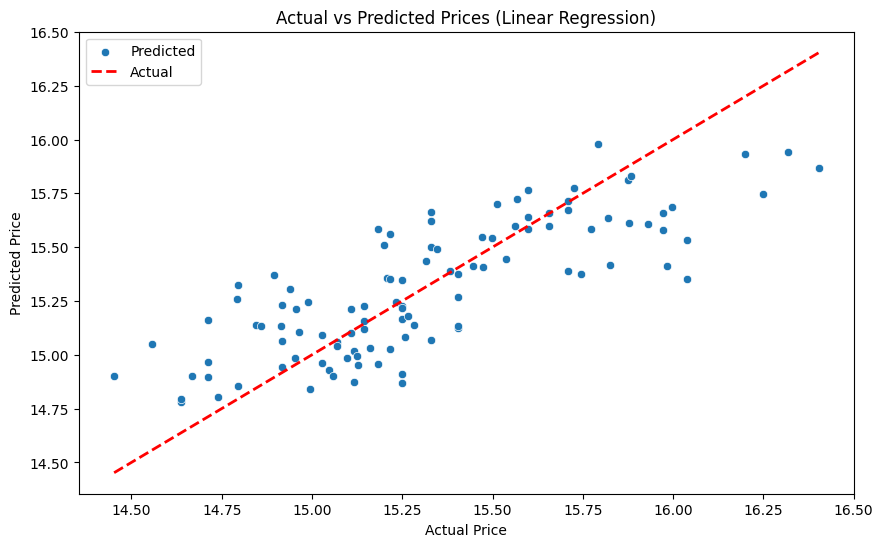

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Plot the actual vs predicted prices
plt.figure(figsize=(10, 6))
sns.scatterplot(x="log_price", y="raw_prediction", data=pd_holdout_lr)
plt.title("Actual vs Predicted Prices (Linear Regression)")
plt.xlabel("Actual Price")
plt.ylabel("Predicted Price")
plt.plot([pd_holdout_lr["log_price"].min(), pd_holdout_lr["log_price"].max()],
         [pd_holdout_lr["log_price"].min(), pd_holdout_lr["log_price"].max()],
         color='red', lw=2, linestyle='--')
plt.legend(['Predicted', 'Actual'])
plt.show()

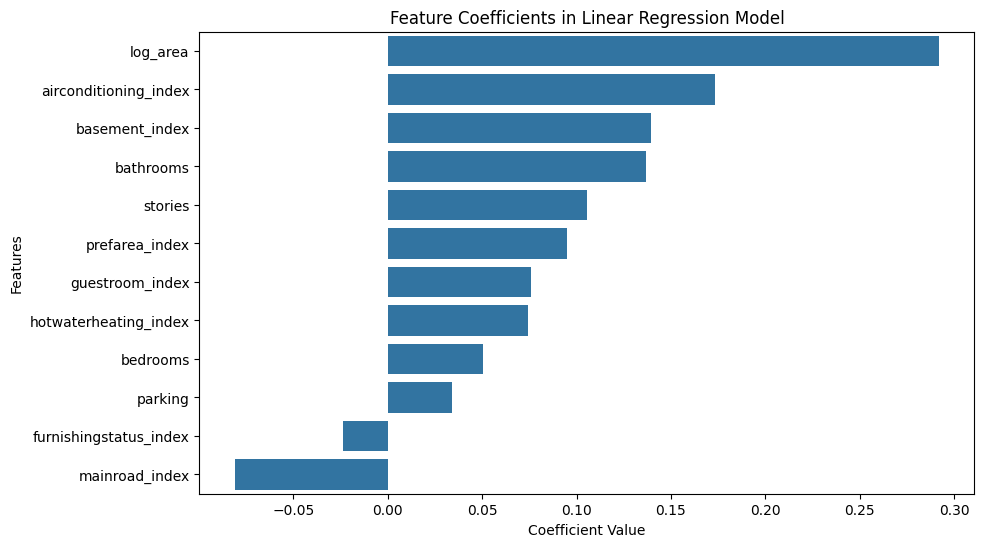

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Assuming model_lr is your CrossValidatorModel instance from PySpark
best_lr_model = model_lr.bestModel  # This is your LinearRegressionModel

# Extract coefficients
coefficients = best_lr_model.coefficients.toArray()

# Assuming featureCols is your list of feature names
feature_importance_df = pd.DataFrame(list(zip(featureCols, coefficients)),
                                     columns=["Feature", "Coefficient"])

# Sort the DataFrame by the coefficients
feature_importance_df = feature_importance_df.sort_values(by="Coefficient", ascending=False)

# Plotting
import matplotlib.pyplot as plt
import seaborn as sns
plt.figure(figsize=(10, 6))
sns.barplot(x="Coefficient", y="Feature", data=feature_importance_df)
plt.title("Feature Coefficients in Linear Regression Model")
plt.xlabel("Coefficient Value")
plt.ylabel("Features")
plt.show()